In [1]:
# dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import data
import pandas as pd 
application_df = pd.read_csv("resources/charity_data.csv")
application_df.head()

2022-10-03 15:29:12.971499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(['EIN','NAME'],axis=1)
application_df.columns

Index(['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE',
       'ORGANIZATION', 'STATUS', 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS',
       'ASK_AMT', 'IS_SUCCESSFUL'],
      dtype='object')

In [3]:
application_df.ASK_AMT.value_counts()

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [4]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [5]:
# Look at APPLICATION_TYPE value counts for binning
application_df['APPLICATION_TYPE'].value_counts()

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [6]:
# Determine which values to replace if counts are less than 700
apptype_counts = application_df['APPLICATION_TYPE'].value_counts()

replace_apptypes = list(apptype_counts[apptype_counts<500].index)

# replace within the dataframe
for apptype in replace_apptypes:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(apptype, "Other")
    
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [7]:
# Look at CLASSIFICATION value counts for binning
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [8]:
# Determine which values to replace if counts are less than ..?
class_counts = application_df['CLASSIFICATION'].value_counts()

replace_class = list(class_counts[class_counts<1800].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

### Optimization 1: Change income amount from categorical to numeric
- Instead of using dummy variables for each bin, use the median numeric value for each bin
- Choosing 70M as an arbitrary stand-in for amounts > 50M

In [9]:
# custom function to numericize binned 'INCOME_AMT' data
def numeric_income(row):
    income = row['INCOME_AMT']
    if income == '0':
        numeric_income = 0
    elif income == '1-9999':
        numeric_income = np.median([1,9999])
    elif income == '10000-24999':
        numeric_income = np.median([10000,24999])
    elif income == '25000-99999':
        numeric_income = np.median([25000,99999])
    elif income == '100000-499999':
        numeric_income = np.median([100000,499999])
    elif income == '1M-5M':
        numeric_income = np.median([1e6,5e6])
    elif income == '5M-10M':
        numeric_income = np.median([5e6,10e6])
    elif income == '10M-50M':
        numeric_income = np.median([10e6,50e6])
    elif income == '50M+':
        numeric_income = np.median([70e6]) # arbitrary
    else: 
        numeric_income = income
    return numeric_income

# Replace in dataframe
application_df.INCOME_AMT = application_df.apply(numeric_income, axis=1)

0.0           24388
62499.5        3747
299999.5       3374
3000000.0       955
5000.0          728
17499.5         543
30000000.0      240
7500000.0       185
70000000.0      139
Name: INCOME_AMT, dtype: int64


<AxesSubplot:ylabel='Density'>

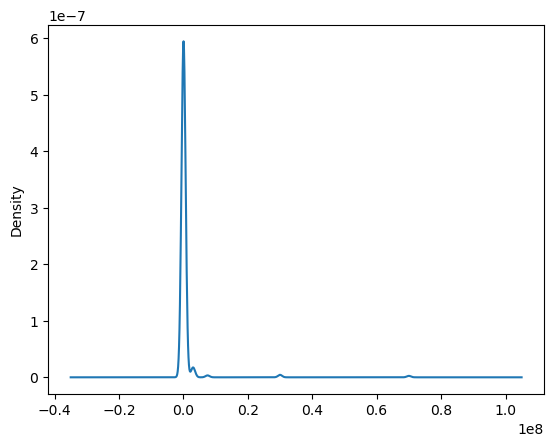

In [10]:
# check the counts of each newly-numericized bin
print(application_df.INCOME_AMT.value_counts())
application_df.INCOME_AMT.plot.density()

In [11]:
# Generate categorical variable lists
cat_vars = application_df.dtypes[application_df.dtypes == "object"].index.tolist()

In [12]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[cat_vars]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat_vars)
encode_df.head()

/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [13]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index=True)
application_df = application_df.drop(cat_vars,1)
application_df.head()

/var/folders/sl/tgxsvd7x1sgfd5nbn3xfjc4m0000gn/T/ipykernel_45889/3453191861.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  application_df = application_df.drop(cat_vars,1)


,STATUS,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,...,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,0.0,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,5000.0,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,0.0,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1,17499.5,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1,299999.5,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [14]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"],1).values

/var/folders/sl/tgxsvd7x1sgfd5nbn3xfjc4m0000gn/T/ipykernel_45889/2621718228.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = application_df.drop(["IS_SUCCESSFUL"],1).values


In [15]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Optimization 2: Add more nodes to the hidden layer
- increasing to 50 from the original 30 nodes

In [17]:
# Define the model 
num_input_features = len(X_train[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 50
#hidden_nodes_layer3 = 20

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=num_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
#nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

2022-10-03 15:29:20.162179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                2880      
                                                                 
 dense_1 (Dense)             (None, 50)                4050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 6,981
Trainable params: 6,981
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
#nn.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=["accuracy"])

In [19]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("model_checkpoints/",exist_ok=True)
checkpoint_path = "model_checkpoints/optimized_weights.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    # save_freq='epoch',
    period=5)

### Optimization 3: Add more epochs to the training regimen
- increased to 200 from 100

In [20]:
# Train the model
fit_model = nn.fit(X_train, y_train, epochs=200, callbacks=[cp_callback])

Epoch 1/200
804/804 [==============================] - 2s 1ms/step - loss: 30554.6836 - accuracy: 0.4944
Epoch 2/200
804/804 [==============================] - 1s 1ms/step - loss: 46979.0156 - accuracy: 0.4880
Epoch 3/200
804/804 [==============================] - 1s 1ms/step - loss: 22514.8359 - accuracy: 0.4881
Epoch 4/200
804/804 [==============================] - 1s 1ms/step - loss: 36593.8828 - accuracy: 0.4924
Epoch 5/200
790/804 [============================>.] - ETA: 0s - loss: 42088.6328 - accuracy: 0.4877
Epoch 5: saving model to model_checkpoints/optimized_weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 41542.8125 - accuracy: 0.4882
Epoch 6/200
804/804 [==============================] - 1s 1ms/step - loss: 11611.0703 - accuracy: 0.4965
Epoch 7/200
804/804 [==============================] - 1s 1ms/step - loss: 9275.1914 - accuracy: 0.5026
Epoch 8/200
804/804 [==============================] - 1s 1ms/step - loss: 9180.1035 - accuracy: 0.4927
Epoc

804/804 [==============================] - 1s 1ms/step - loss: 0.6918 - accuracy: 0.5267
Epoch 63/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6923 - accuracy: 0.5282
Epoch 64/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6917 - accuracy: 0.5306
Epoch 65/200
798/804 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.5314
Epoch 65: saving model to model_checkpoints/optimized_weights.65.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.6920 - accuracy: 0.5313
Epoch 66/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6918 - accuracy: 0.5309
Epoch 67/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6919 - accuracy: 0.5330
Epoch 68/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6919 - accuracy: 0.5297
Epoch 69/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6919 - accuracy: 0.5279
Epoch 70/200
778/804 [====================

804/804 [==============================] - 1s 1ms/step - loss: 0.6917 - accuracy: 0.5322
Epoch 124/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6918 - accuracy: 0.5271
Epoch 125/200
775/804 [===========================>..] - ETA: 0s - loss: 0.6916 - accuracy: 0.5307
Epoch 125: saving model to model_checkpoints/optimized_weights.125.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.6916 - accuracy: 0.5305
Epoch 126/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6915 - accuracy: 0.5318
Epoch 127/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6920 - accuracy: 0.5303
Epoch 128/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6915 - accuracy: 0.5316
Epoch 129/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6917 - accuracy: 0.5306
Epoch 130/200
771/804 [===========================>..] - ETA: 0s - loss: 0.6917 - accuracy: 0.5301
Epoch 130: saving model to model_chec

804/804 [==============================] - 1s 1ms/step - loss: 0.6916 - accuracy: 0.5330
Epoch 185/200
783/804 [============================>.] - ETA: 0s - loss: 0.6913 - accuracy: 0.5329
Epoch 185: saving model to model_checkpoints/optimized_weights.185.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.6913 - accuracy: 0.5328
Epoch 186/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6915 - accuracy: 0.5330
Epoch 187/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6918 - accuracy: 0.5326
Epoch 188/200
804/804 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.5325
Epoch 189/200
804/804 [==============================] - 1s 1ms/step - loss: 0.6918 - accuracy: 0.5301
Epoch 190/200
791/804 [============================>.] - ETA: 0s - loss: 0.6916 - accuracy: 0.5317
Epoch 190: saving model to model_checkpoints/optimized_weights.190.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.691

In [21]:
# Evaluate the model's loss and accuracy using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 1.1289 - accuracy: 0.6444 - 388ms/epoch - 1ms/step
Loss: 1.128853678703308, Accuracy: 0.644431471824646


## Results:
### original: 0.891 loss, 63.8% accuracy
### optimized: 0.691 loss, 72.2% accuracy

In [22]:
# Save and export the model to an hd5 file
nn.save("AlphabetSoupCharity_Optimization.h5")